# How does the EIA weekly announcement of oil storage levels impact the day-to-day WTI crude oil close price?

- Using close as a proxy for intraday due to data availability.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

import statsmodels.api as sm

In [2]:
# EIA Weekly Report of oil storage inventory
storage_data_fp = "data/weekly_us_crude_stocks.xls"

storage_df = pd.read_excel(storage_data_fp, sheet_name="Data 1", skiprows=[0, 1])
storage_df.rename(columns={"Date": "date", storage_df.columns[1]: "oil_stock"}, inplace=True, errors="raise")

storage_df.set_index("date", inplace=True)
storage_df.index = pd.to_datetime(storage_df.index)
storage_df.tail()

,oil_stock
date,
2022-12-30,420646
2023-01-06,439607
2023-01-13,448015
2023-01-20,448548
2023-01-27,452688


In [3]:
# WTI Crude Oil Price - rolling front month
ticker = "CL=F"
start_date = "2017-01-01"
end_date = "2022-10-14"
interval = "1d"

price_df = yf.download(ticker, start=start_date, end=end_date, interval=interval)
price_df.index = pd.to_datetime(price_df.index)

price_df = price_df[["Close", "Volume"]]
price_df.columns= price_df.columns.str.lower()

price_df.dropna(inplace=True)
price_df.tail()

[*********************100%***********************]  1 of 1 completed


/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_3989/605244384.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df.dropna(inplace=True)


,close,volume
Date,,
2022-10-07,92.639999,429162
2022-10-10,91.129997,289508
2022-10-11,89.349998,333158
2022-10-12,87.269997,332271
2022-10-13,89.110001,298032


# Daily View

In [4]:
df_daily = price_df.join(storage_df)

# Forward fill NaNs: fill NaN values with the last non-NaN to propagate the weekly oil storage level to each day,
df_daily.fillna(method="ffill", inplace=True)

# Drop the leading NaNs that cannot be forward-filled
df_daily.dropna(inplace=True)

df_daily.tail()

,close,volume,oil_stock
Date,,,
2022-10-07,92.639999,429162,439082.0
2022-10-10,91.129997,289508,439082.0
2022-10-11,89.349998,333158,439082.0
2022-10-12,87.269997,332271,439082.0
2022-10-13,89.110001,298032,439082.0


In [5]:
df_daily["d_close"] = df_daily["close"].pct_change()
df_daily["d_oil_stock"] = df_daily["oil_stock"].pct_change()
df_daily.dropna(inplace=True)
df_daily.tail()

,close,volume,oil_stock,d_close,d_oil_stock
Date,,,,,
2022-10-07,92.639999,429162,439082.0,0.047371,0.023017
2022-10-10,91.129997,289508,439082.0,-0.016300,0.000000
2022-10-11,89.349998,333158,439082.0,-0.019533,0.000000
2022-10-12,87.269997,332271,439082.0,-0.023279,0.000000
2022-10-13,89.110001,298032,439082.0,0.021084,0.000000


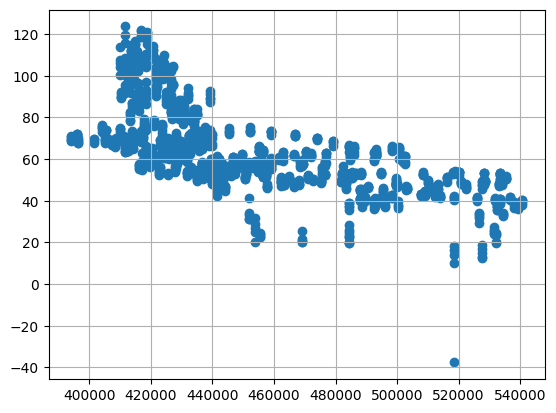

In [15]:
plt.scatter(df_daily["oil_stock"], df_daily["close"])
plt.grid()
plt.show()

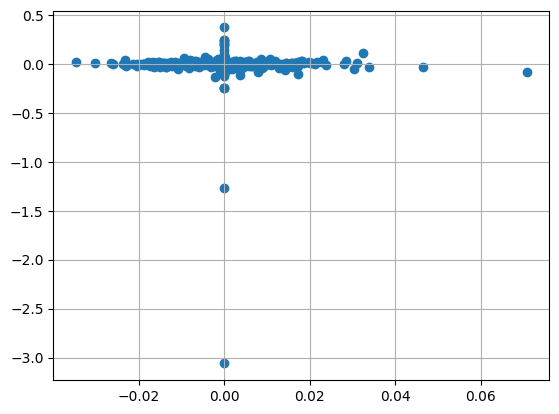

In [6]:
plt.scatter(df_daily["d_oil_stock"], df_daily["d_close"])
plt.grid()
plt.show()

# Weekly View

In [7]:
df_weekly = price_df.join(storage_df)

# Drop non-report days
df_weekly.dropna(inplace=True)

df_weekly.tail()

,close,volume,oil_stock
Date,,,
2022-09-09,86.790001,305188,429633.0
2022-09-16,85.110001,87829,430774.0
2022-09-23,78.739998,334271,430559.0
2022-09-30,79.489998,253154,429203.0
2022-10-07,92.639999,429162,439082.0


In [8]:
# Returns: r_t = (p_t/p_{t-1}) - 1
df_weekly["return"] = df_weekly["close"].pct_change()
df_weekly["log_return"] = np.log(df_weekly["close"]/df_weekly["close"].shift(1))

df_weekly["d_volume"] = df_weekly["volume"].pct_change()
df_weekly["d_oil_stock"] = df_weekly["oil_stock"].pct_change()

df_weekly.dropna(inplace=True)
df_weekly.tail()

,close,volume,oil_stock,return,log_return,d_volume,d_oil_stock
Date,,,,,,,
2022-09-09,86.790001,305188,429633.0,-0.000921,-0.000921,0.099646,0.005716
2022-09-16,85.110001,87829,430774.0,-0.019357,-0.019547,-0.712213,0.002656
2022-09-23,78.739998,334271,430559.0,-0.074844,-0.077793,2.805930,-0.000499
2022-09-30,79.489998,253154,429203.0,0.009525,0.009480,-0.242668,-0.003149
2022-10-07,92.639999,429162,439082.0,0.165430,0.153090,0.695261,0.023017


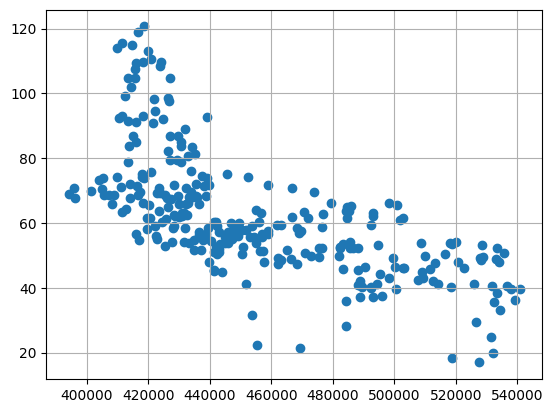

In [14]:
plt.scatter(df_weekly["oil_stock"], df_weekly["close"])
plt.grid()
plt.show()

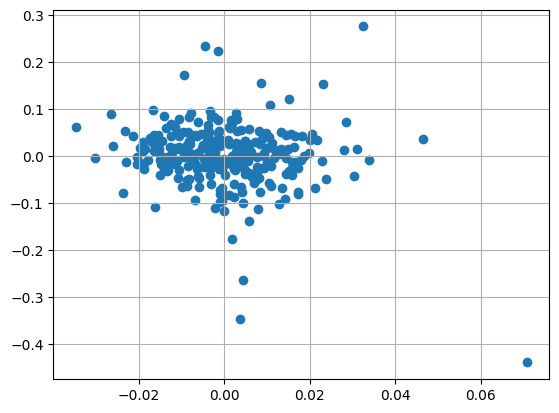

In [9]:
plt.scatter(df_weekly["d_oil_stock"], df_weekly["log_return"])
plt.grid()
plt.show()

In [10]:
X = df_weekly["d_oil_stock"]
y = sm.add_constant(df_weekly["return"])

model = sm.OLS(endog=X, exog=y)
results = model.fit()
results.params

const    -0.000138
return   -0.028086
dtype: float64

In [11]:
X = df_weekly["d_oil_stock"]
y = sm.add_constant(df_weekly["d_volume"])

model = sm.OLS(endog=X, exog=y)
results = model.fit()
results.params

const      -0.000020
d_volume   -0.000716
dtype: float64

In [12]:
correlation_df = df_weekly[["log_return", "d_volume", "d_oil_stock"]].corr()

correlation_df \
    .style.background_gradient(cmap="coolwarm", axis=None, vmin=-1, vmax=1) \
    .highlight_null(null_color='#f1f1f1') \
    .set_precision(3)

/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_3989/1330877952.py:3: FutureWarning: `null_color` is deprecated: use `color` instead
  correlation_df \
/var/folders/2v/xw5v0n3d5rlf442fyyzb04dc0000gn/T/ipykernel_3989/1330877952.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlation_df \


,log_return,d_volume,d_oil_stock
log_return,1.000,-0.023,-0.170
d_volume,-0.023,1.000,-0.063
d_oil_stock,-0.170,-0.063,1.000


# Predict Next Day's Close with and without storage features

# T-Test